In [1]:
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)

c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


263 Pembroke 0.23831906914710999
273 dingo 0.09592907130718231
248 Eskimo dog 0.0682666003704071
264 Cardigan 0.0599789172410965
253 basenji 0.0277384165674448


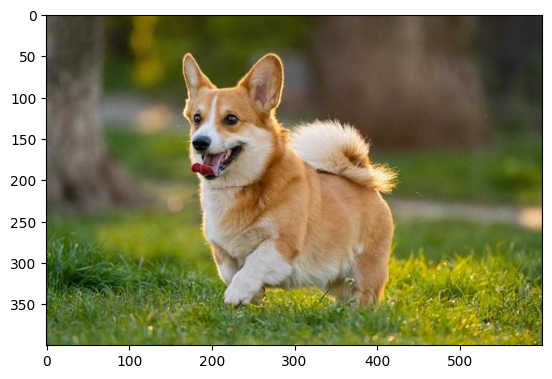

In [2]:
# test the pretrained model using a sample image

input_image = Image.open("data/dog.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to(device) # create a mini-batch as expected by the model


model.eval()
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Read the categories
with open("data/imgnet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

# Show the image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.asarray(input_image))
plt.show()

In [3]:
from lime import BinarySampler, LIMEExplainer, ExponentialKernel
from skimage.segmentation import slic

instance = np.asarray(input_image)
print(instance.shape)
segments = slic(instance, n_segments=25, compactness=10)

kernel = ExponentialKernel(1e5)
sampler = BinarySampler(segments, n_jobs=8, alpha=0.7)
explainer = LIMEExplainer(similarity_kernel=kernel, sampler=sampler, model=model, preprocess=preprocess)

(400, 600, 3)


In [4]:
# explain Pembroke
importances = explainer.explain(instance, class_to_explain=263, n_pertubations=700)

KeyboardInterrupt: 

In [4]:
from lime import FlowSampler
from glow import GLOW
import pickle

from torchvision.datasets import CelebA

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_location=torch.device('cpu')))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

image = Image.open('data/000010.jpg')
instance = np.asarray(transform(image))


latent_manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))

segments = slic(instance, n_segments=25, compactness=10)
sampler = FlowSampler(flow, latent_manipulators, segments)



sampler.sample(instance, 1)

c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torch\_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1994.)
  LU, pivots, infos = torch._lu_with_info(
C:\Users\luana\AppData\Local\Temp\ipykernel_6216\1328787572.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will exec

torch.Size([3, 256, 256])
torch.Size([1, 48, 32, 32]) torch.Size([1, 48, 12, 12])


RuntimeError: The size of tensor a (32) must match the size of tensor b (12) at non-singleton dimension 3